In [3]:
pip install psycopg2-binary sqlalchemy pandas matplotlib seaborn


Note: you may need to restart the kernel to use updated packages.


In [6]:
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

username = "postgres"
password = quote_plus("Jaadu@1007")  # encode @ symbol
host = "localhost"
port = "5432"
database = "retail_db"

# Create connection engine
engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}")

# Test connection
with engine.connect() as conn:
    result = conn.execute(text("SELECT version();"))
    for row in result:
        print("✅ Connected to:", row[0])


✅ Connected to: PostgreSQL 17.6 on x86_64-windows, compiled by msvc-19.44.35213, 64-bit


In [7]:
# Create transactions table
with engine.begin() as conn:
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS transactions (
            transaction_id SERIAL PRIMARY KEY,
            event_ts TIMESTAMP,
            customer_email VARCHAR(100),
            sku VARCHAR(20),
            store_name VARCHAR(50),
            quantity INT,
            total_amount FLOAT
        );
    """))
print("✅ Table 'transactions' created successfully.")


✅ Table 'transactions' created successfully.


In [8]:
from datetime import datetime
import random

# Sample data for insertion
stores = ['Pune Central', 'Phoenix Mall', 'Amanora Mall', 'Seasons Mall']
skus = ['SKU101', 'SKU102', 'SKU103', 'SKU104']
customers = ['john@example.com', 'maya@example.com', 'rahul@example.com', 'neha@example.com']

data = []
for i in range(50):
    record = (
        datetime(2025, 10, random.randint(1, 28), random.randint(8, 22), random.randint(0, 59)),
        random.choice(customers),
        random.choice(skus),
        random.choice(stores),
        random.randint(1, 5),
        round(random.uniform(100, 1500), 2)
    )
    data.append(record)

# Insert into PostgreSQL
insert_query = text("""
    INSERT INTO transactions (event_ts, customer_email, sku, store_name, quantity, total_amount)
    VALUES (:event_ts, :customer_email, :sku, :store_name, :quantity, :total_amount)
""")

with engine.begin() as conn:
    conn.execute(insert_query, [
        {'event_ts': d[0], 'customer_email': d[1], 'sku': d[2], 'store_name': d[3],
         'quantity': d[4], 'total_amount': d[5]} for d in data
    ])

print("✅ 50 Sample transactions inserted successfully.")


✅ 50 Sample transactions inserted successfully.


In [9]:
import pandas as pd

# Read data from PostgreSQL
query = "SELECT * FROM transactions;"
df = pd.read_sql(query, engine)

print("📊 Raw Data Preview:")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Cleaning steps
df['quantity'] = df['quantity'].fillna(0)
df['total_amount'] = df['total_amount'].fillna(0)
df = df.drop_duplicates()
df['event_ts'] = pd.to_datetime(df['event_ts'])
df = df[df['quantity'] > 0]
df = df[df['total_amount'] > 0]

print("\n✅ Cleaned data info:")
df.info()


📊 Raw Data Preview:


,transaction_id,event_ts,customer_email,sku,store_name,quantity,total_amount
0,1,2025-10-10 08:25:00,neha@example.com,SKU104,Seasons Mall,1,500.91
1,2,2025-10-07 21:59:00,john@example.com,SKU102,Pune Central,5,741.08
2,3,2025-10-20 11:43:00,neha@example.com,SKU104,Pune Central,3,300.36
3,4,2025-10-20 14:21:00,neha@example.com,SKU103,Phoenix Mall,4,568.44
4,5,2025-10-13 20:26:00,john@example.com,SKU104,Amanora Mall,4,508.85



Missing values per column:
transaction_id    0
event_ts          0
customer_email    0
sku               0
store_name        0
quantity          0
total_amount      0
dtype: int64

✅ Cleaned data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  50 non-null     int64         
 1   event_ts        50 non-null     datetime64[ns]
 2   customer_email  50 non-null     object        
 3   sku             50 non-null     object        
 4   store_name      50 non-null     object        
 5   quantity        50 non-null     int64         
 6   total_amount    50 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 2.9+ KB


In [10]:
# Total revenue
total_revenue = df['total_amount'].sum()
print(f"💰 Total Revenue: ₹{total_revenue:.2f}")

# Average order value
avg_order = df['total_amount'].mean()
print(f"🧾 Average Order Value: ₹{avg_order:.2f}")

# Top performing store
top_store = df.groupby('store_name')['total_amount'].sum().idxmax()
print(f"🏬 Top Performing Store: {top_store}")

# Sales summary per store
store_sales = df.groupby('store_name')['total_amount'].sum().reset_index()
store_sales


💰 Total Revenue: ₹36645.85
🧾 Average Order Value: ₹732.92
🏬 Top Performing Store: Pune Central


,store_name,total_amount
0,Amanora Mall,5046.80
1,Phoenix Mall,9429.02
2,Pune Central,13548.93
3,Seasons Mall,8621.10


C:\Users\Admin\AppData\Local\Temp\ipykernel_29600\495454978.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='store_name', y='total_amount', data=store_sales, palette='Blues_d')


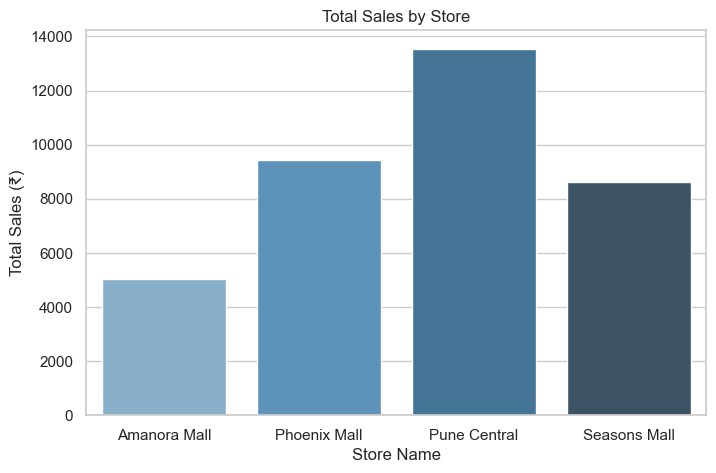

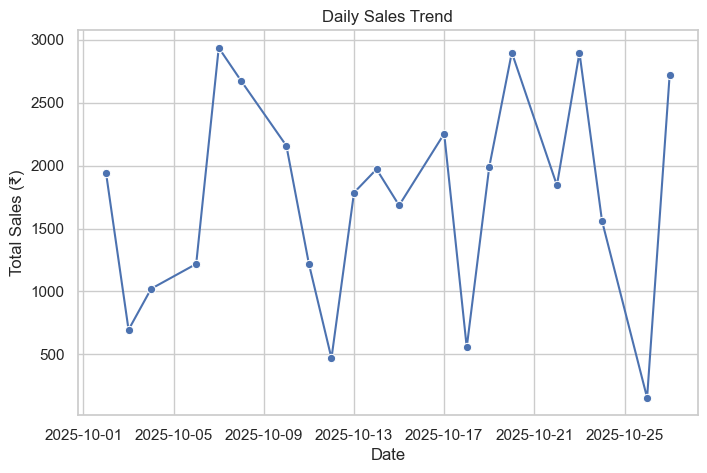

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# 1️⃣ Sales by Store
plt.figure(figsize=(8,5))
sns.barplot(x='store_name', y='total_amount', data=store_sales, palette='Blues_d')
plt.title('Total Sales by Store')
plt.xlabel('Store Name')
plt.ylabel('Total Sales (₹)')
plt.show()

# 2️⃣ Sales Trend Over Time
df['date'] = df['event_ts'].dt.date
daily_sales = df.groupby('date')['total_amount'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(x='date', y='total_amount', data=daily_sales, marker='o')
plt.title('Daily Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales (₹)')
plt.show()
